# **Proyek Klasifikasi Gambar: diamond-images-dataset**
- **Nama:** Mario Valerian Rante Ta'dung
- **Email:** rantetadungrio@gmail.com
- **ID Dicoding:** riooorante

# **Import Semua Packages/Library yang Digunakan**

In [1]:
!pip install --upgrade packaging -q

In [116]:
!pip install visualkeras split-folders kaggle tensorflowjs visualkeras -q

In [117]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import splitfolders
import kagglehub
import warnings
import math
import pathlib
import visualkeras

from tensorflow import keras
from sklearn.metrics import classification_report
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                     BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score


warnings.filterwarnings('ignore')
%matplotlib inline

## **Data Preparation**

### **Data Loading**

In [4]:
data_path = kagglehub.dataset_download("aayushpurswani/diamond-images-dataset")

temp_data_path = './temp_dataset'

if os.path.exists(temp_data_path):
    shutil.rmtree(temp_data_path)

100%|██████████| 3.08G/3.08G [02:20<00:00, 23.5MB/s]

Extracting files...


In [5]:
full_path = os.path.join(data_path, 'web_scraped')

selected_folder = [folder for folder in os.listdir(full_path) if folder not in ['diamond_data.csv', 'marquise']]

> Data yang diambil hanya 1500 setiap kelas untuk membuat proses training lebih ringan.

In [6]:
for folder in selected_folder:
    files = random.sample(os.listdir(os.path.join(full_path, folder)), 1500)

    os.makedirs(os.path.join(temp_data_path, folder), exist_ok=True)

    for file in files:
        shutil.copy(os.path.join(full_path, folder, file), os.path.join(temp_data_path, folder))

In [7]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [8]:
print_images_resolution(temp_data_path)

cushion: 1500
- (591, 464)
- (601, 475)
- (505, 397)
- (515, 407)
- (597, 489)
- (512, 402)
- (529, 418)
- (523, 411)
- (589, 466)
- (579, 458)
- (542, 427)
- (600, 471)
- (557, 454)
- (600, 489)
- (515, 402)
- (531, 420)
- (567, 449)
- (551, 432)
- (528, 430)
- (544, 426)
- (538, 425)
- (600, 473)
- (509, 398)
- (545, 430)
- (497, 390)
- (557, 440)
- (600, 475)
- (512, 401)
- (548, 430)
- (566, 445)
- (518, 405)
- (577, 454)
- (499, 391)
- (501, 394)
- (569, 446)
- (493, 390)
- (495, 387)
- (538, 440)
- (519, 408)
- (589, 461)
- (599, 471)
- (589, 589)
- (525, 412)
- (532, 417)
- (491, 385)
- (508, 401)
- (589, 463)
- (599, 473)
- (567, 444)
- (552, 434)
- (569, 450)
- (521, 410)
- (579, 454)
- (528, 415)
- (597, 469)
- (567, 446)
- (559, 442)
- (504, 396)
- (600, 470)
- (591, 467)
- (548, 432)
- (579, 456)
- (553, 437)
- (535, 423)
- (524, 413)
- (587, 460)
- (504, 398)
- (557, 437)
- (600, 472)
- (600, 600)
- (580, 457)
- (600, 490)
- (546, 430)
- (491, 384)
- (600, 474)
- (534, 419

### **Data Preprocessing**

In [9]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isdir(path):
            for img_filename in os.listdir(path):
                img_path = os.path.join(path, img_filename)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    images.append(np.array(img))
                    labels.append(filename)
                except Exception as e:
                    print(f"Error loading image: {img_path}, {e}")
    return images, labels

In [10]:
def plot_label_distribution(labels, title):
    label_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

#### **Split Dataset**

In [11]:
splitfolders.ratio(temp_data_path, output="/content/dataset", seed=1337, ratio=(.8, .1, .1))
shutil.rmtree(temp_data_path)

Copying files: 10500 files [00:03, 3284.53 files/s]


In [12]:
TRAIN_PATH = '/content/dataset/train'
VAL_PATH = '/content/dataset/val'
TEST_PATH = '/content/dataset/test'

In [13]:
img_train, labels_train = load_images_from_folder(TRAIN_PATH)
img_val, labels_val = load_images_from_folder(VAL_PATH)
img_test, labels_test = load_images_from_folder(TEST_PATH)

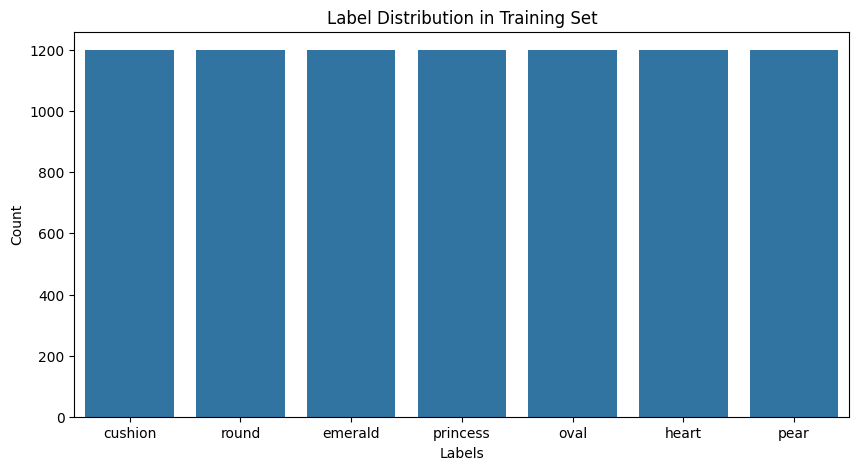

In [14]:
plot_label_distribution(labels_train, 'Label Distribution in Training Set')

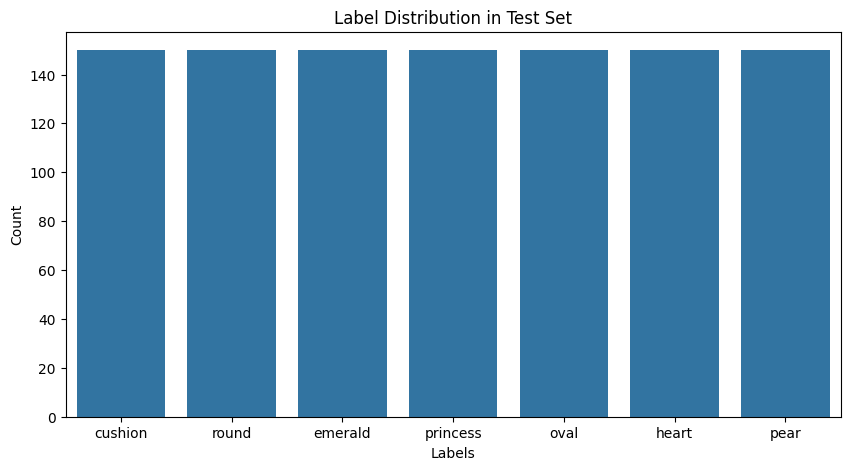

In [15]:
plot_label_distribution(labels_test, 'Label Distribution in Test Set')

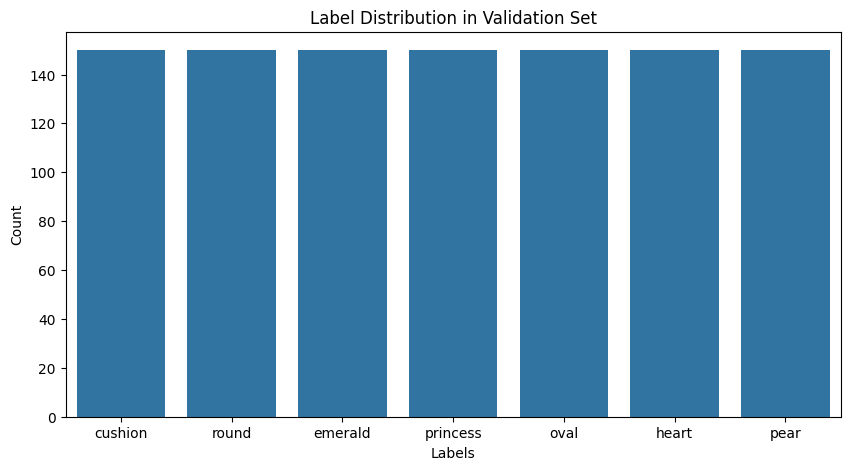

In [16]:
plot_label_distribution(labels_val, 'Label Distribution in Validation Set')

#### **Data Generator**

In [17]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                brightness_range=[0.8, 1.2],
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest',
                shear_range=5,
                channel_shift_range=0.1
              )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 8400 images belonging to 7 classes.
Found 1050 images belonging to 7 classes.
Found 1050 images belonging to 7 classes.


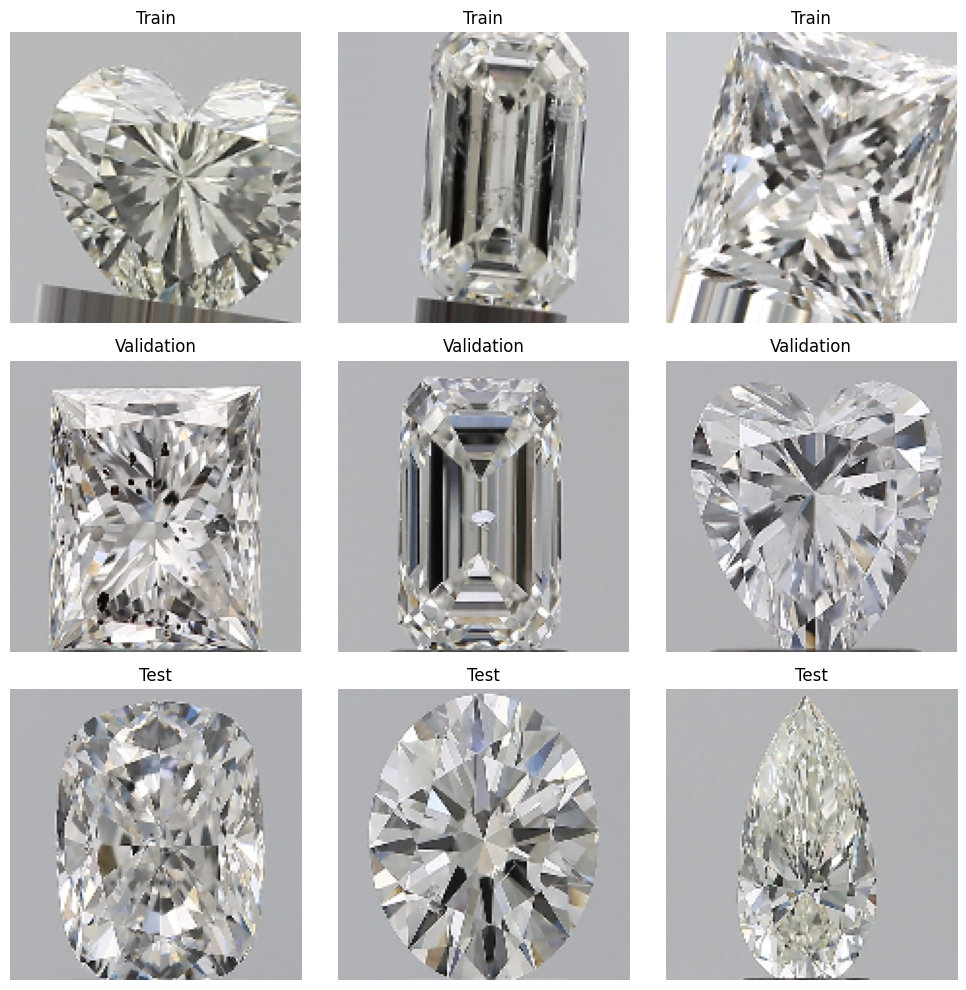

In [19]:
images_train, labels_train = next(train_generator)
images_val, labels_val = next(validation_generator)
images_test, labels_test = next(test_generator)

plt.figure(figsize=(10, 10))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_train[i])
    plt.title("Train")
    plt.axis('off')

for i in range(3):
    plt.subplot(3, 3, i + 4)
    plt.imshow(images_val[i])
    plt.title("Validation")
    plt.axis('off')

for i in range(3):
    plt.subplot(3, 3, i + 7)
    plt.imshow(images_test[i])
    plt.title("Test")
    plt.axis('off')

plt.tight_layout()
plt.show()


## **Modelling**

In [76]:
model = Sequential([
    Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


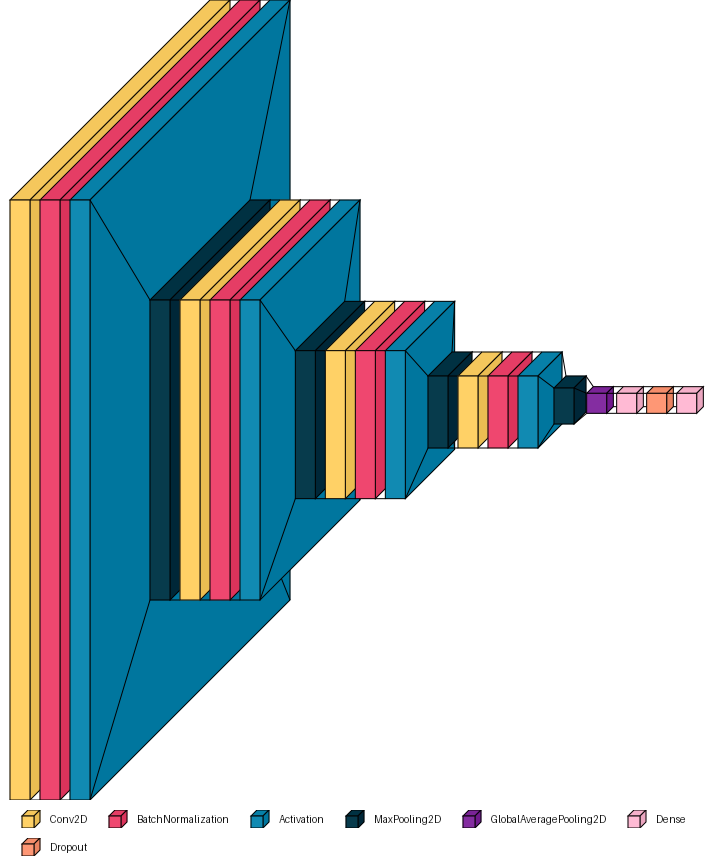

In [121]:
visualkeras.layered_view(model, legend=True)

In [77]:
model_checkpoint = ModelCheckpoint(
    filepath='model_best.h5',
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2
)

class StopTrainingAcc(Callback):
      def __init__(self, target_acc=0.95):
          self.target_acc = target_acc

      def on_epoch_end(self, epoch, logs=None):
          acc = logs.get("accuracy")
          val_acc = logs.get("val_accuracy")

          if acc >= self.target_acc and val_acc >= self.target_acc:
             print(20 * "=")
             print(f"\nAkurasi Sudah Tercapai, Training Dihentikan!")
             print(20 * "=")

             self.model.stop_training = True

stop_train = StopTrainingAcc(0.95)

In [78]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.005),
              metrics=['accuracy'])

In [79]:
steps_per_epoch = math.ceil(8400 / 32)
validation_steps = math.ceil(1500 / 32)

In [80]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[model_checkpoint, reduce_lr, stop_train])

Epoch 1/100


263/263 - 96s - 364ms/step - accuracy: 0.6374 - loss: 0.9186 - val_accuracy: 0.1781 - val_loss: 9.7060 - learning_rate: 0.0050
Epoch 2/100


263/263 - 86s - 328ms/step - accuracy: 0.8388 - loss: 0.4393 - val_accuracy: 0.7524 - val_loss: 0.6570 - learning_rate: 0.0050
Epoch 3/100
263/263 - 140s - 533ms/step - accuracy: 0.8790 - loss: 0.3501 - val_accuracy: 0.5629 - val_loss: 4.1053 - learning_rate: 0.0050
Epoch 4/100
263/263 - 142s - 539ms/step - accuracy: 0.8931 - loss: 0.3191 - val_accuracy: 0.1743 - val_loss: 10.9432 - learning_rate: 0.0050
Epoch 5/100


263/263 - 142s - 539ms/step - accuracy: 0.9407 - loss: 0.2050 - val_accuracy: 0.9619 - val_loss: 0.1223 - learning_rate: 5.0000e-04
Epoch 6/100



Akurasi Sudah Tercapai, Training Dihentikan!
263/263 - 142s - 540ms/step - accuracy: 0.9526 - loss: 0.1714 - val_accuracy: 0.9743 - val_loss: 0.0875 - learning_rate: 5.0000e-04


## **Evaluasi dan Visualisasi**

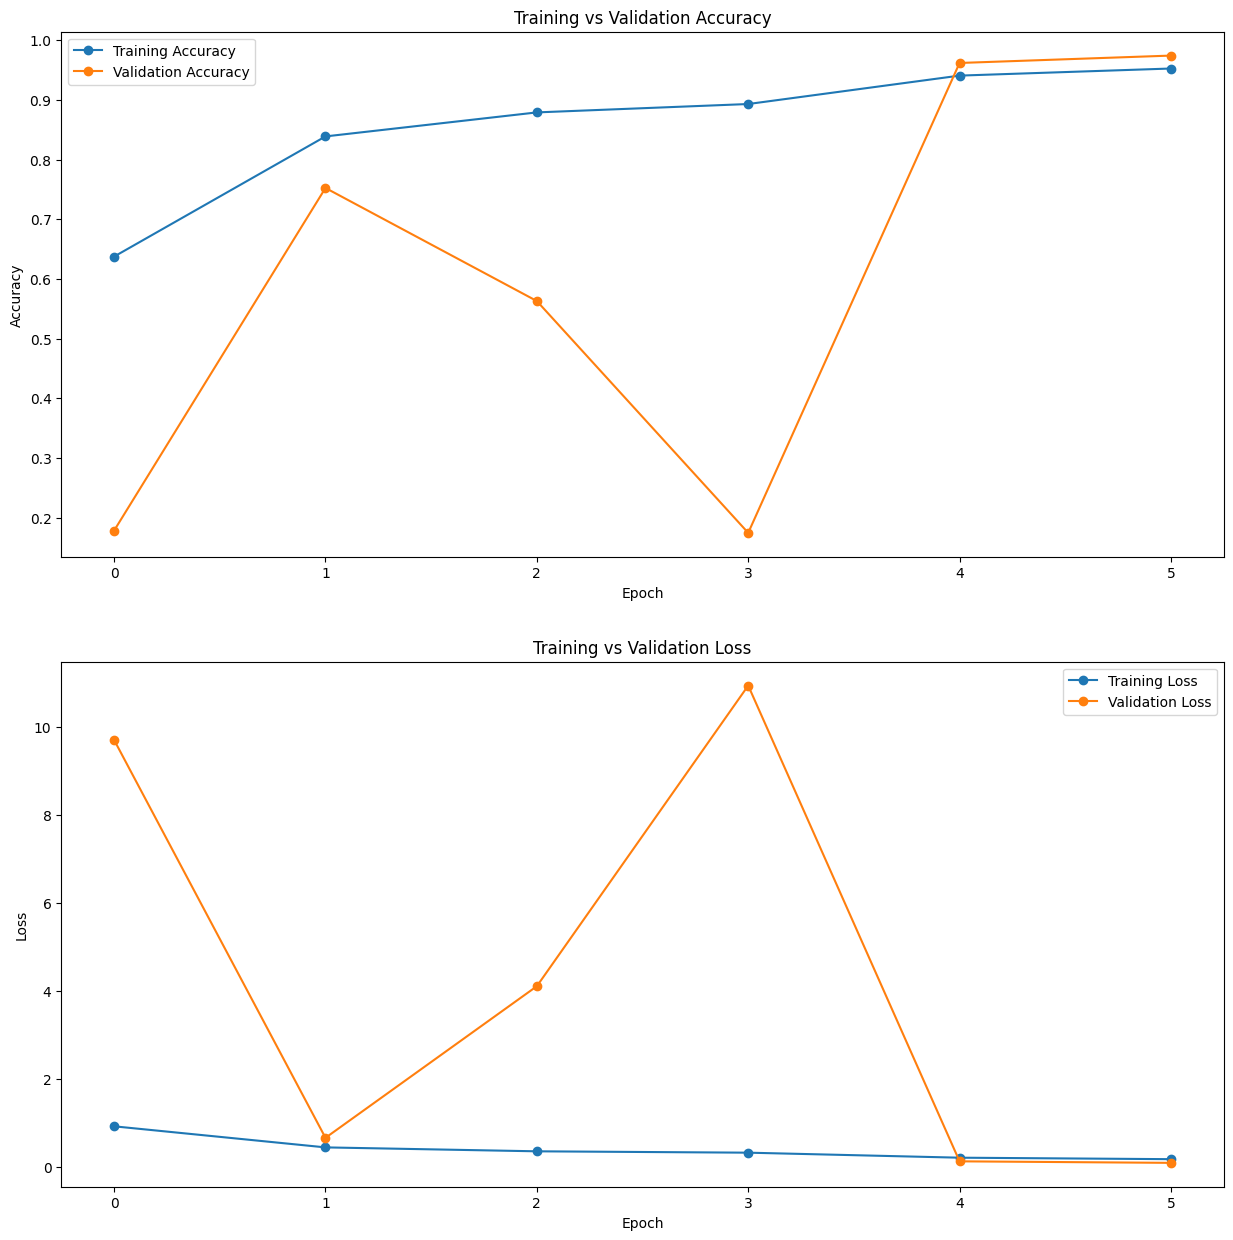

In [81]:
figure, ax = plt.subplots(2,1, figsize=(15, 15))

ax[0].plot(history.history['accuracy'], marker='o', label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax[0].set_title('Training vs Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], marker='o', label='Training Loss')
ax[1].plot(history.history['val_loss'], marker='o', label='Validation Loss')
ax[1].set_title('Training vs Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

### **Prediksi dan Evaluasi pada data test**

In [82]:
test_loss, test_acc = model.evaluate(test_generator, steps=validation_steps, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9775 - loss: 0.0903 
Test Accuracy: 0.9781
Test Loss: 0.0881


## **Konversi Model**

In [83]:
best_model = tf.keras.models.load_model('/content/model_best.h5')

### **Saved Model**

In [84]:
tf.saved_model.save(best_model, '/content/saved_model')

### **Tflite**

In [85]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmp5vl9gxl_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138827171709968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171716496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171720528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171721680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171718032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171717072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171721296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171721488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171718992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171718608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138827171724

464600

In [86]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

with open('label.txt', 'w') as f:
    for i in range(len(labels)):
        f.write(f"{labels[i]}\n")

### **TFJS**

In [87]:
!tensorflowjs_converter --input_format=keras /content/model_best.h5 tfjs_model

2025-04-15 14:38:34.024144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744727914.301183   51422 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744727914.372236   51422 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## **Inference (Optional)**

### **Saved Model**

Saving Dvs2med.jpg to Dvs2med (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Berlian ini berbentuk 'round'


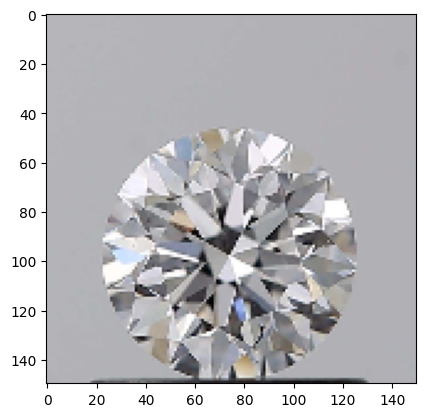

In [96]:
inference_layer = tf.keras.layers.TFSMLayer('/content/saved_model', call_endpoint='serving_default')

input_tensor = keras.Input(shape=(150, 150, 3))
output_tensor = inference_layer(input_tensor)
inference_model = keras.Model(inputs=input_tensor, outputs=output_tensor)

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])

  prediksi = inference_model.predict(images, batch_size=10)
  hasil = labels[np.argmax(prediksi['output_0'][0])]
  print(f"Berlian ini berbentuk '{hasil}'")

Saving Screenshot 2025-04-15 225504.png to Screenshot 2025-04-15 225504.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Berlian ini berbentuk 'emerald'


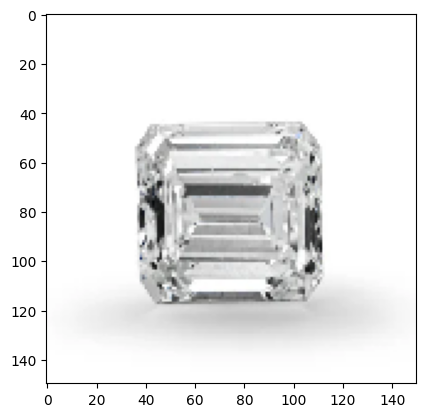

In [106]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])

  prediksi = best_model.predict(images, batch_size=10)
  hasil = labels[np.argmax(prediksi[0])]
  print(f"Berlian ini berbentuk '{hasil}'")

# **Compress Folders**

In [107]:
!zip -r tflite.zip /content/tflite

  adding: content/tflite/ (stored 0%)
  adding: content/tflite/model.tflite (deflated 8%)
  adding: content/tflite/label.txt (deflated 4%)


In [108]:
!zip -r tfjs_model.zip /content/tfjs_model

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/model.json (deflated 90%)
  adding: content/tfjs_model/group1-shard1of1.bin (deflated 7%)


In [109]:
!zip -r saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/model_best.h5 (deflated 15%)
  adding: content/saved_model/saved_model.pb (deflated 87%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 61%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)


In [112]:
!pip freeze /content/requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aggdraw==1.3.19
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.7.0.35.30
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community